In [1]:
import pandas as pd
import numpy as np
import itertools
import pickle
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from statistics import mean, stdev
from scipy import stats, spatial
import antropy as ant
from ptflops import get_model_complexity_info

from main.layout import Layout
from main.models import Deeplab_ASPP_Layout
from main.algorithms import enum_layout, remove_redundancy, enum_layout_wo_rdt, metric_inference, init_S, coarse_to_fined

In [28]:
# Enum all layouts for given T (3 for NYUv2) and B (5 for coarse Deeplab_Resnet34)
data = 'NYUv2'
model = 'resnet'

T = 3 # segment_semantic, normal, depth_zbuffer
B = 5 
coarse = True

layout_list = [] 
S0 = init_S(T, B) # initial state
L = Layout(T, B, S0) # initial layout
layout_list.append(L)

enum_layout_wo_rdt(L, layout_list)
len(layout_list)

51

In [25]:
# Enum all layouts for given T (3 for NYUv2) and B (9 for coarse MobileNetv2)
data = 'NYUv2'
model = 'mobilenet'

T = 3 # segment_semantic, normal, depth_zbuffer
B = 6 # 9 - coarse v1, 6 - coarse v2
coarse = True

layout_list = [] 
S0 = init_S(T, B) # initial state
L = Layout(T, B, S0) # initial layout
layout_list.append(L)

enum_layout_wo_rdt(L, layout_list)
len(layout_list)

70

In [26]:
est_metric = 'val_acc'
real_metric = 'val_acc'
est_date = '0105'
real_date = '1214'

# Load 2-Task

In [27]:
two_task_pd = pd.read_excel('./2task/' + data + '_2task_metrics_' + model + '_' + est_date + '_' + est_metric +'.xlsx',engine='openpyxl',index_col=0)

In [28]:
two_task_pd

,"(0, 1)-0","(0, 1)-1","(0, 2)-0","(0, 2)-1","(1, 2)-0","(1, 2)-1"
branch,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-3.756551,0.206613,1.101209,0.762078,-17.952050,-2.634157
2,-3.049282,-1.543906,2.578223,6.642063,-19.258973,-6.995612
3,-3.226608,-0.321529,2.155586,6.293724,-19.137206,-0.629648
4,-2.031691,0.910665,-0.233959,8.740496,-18.621772,3.480578
5,-2.002587,0.273969,-0.564342,8.774514,-19.128467,1.241206
6,-1.960275,2.428915,-1.746122,12.325905,-18.827467,1.628834


In [29]:
tasks = [i for i in range(T)]
two_task_metrics = {}
for two_set in itertools.combinations(tasks, 2):
    two_task_metrics[two_set] = []
    for b in range(0, B+1): 
        metric1 = two_task_pd[str(two_set)+'-0'][b]
        metric2 = two_task_pd[str(two_set)+'-1'][b]
        two_task_metrics[two_set].append([metric1, metric2])

In [30]:
fluc = {}
for t in tasks:
    fluc[t] = []
    
for two_set in itertools.combinations(tasks, 2):
    print(two_set)
    for idx in range(2):
        metric = two_task_pd[str(two_set)+'-'+str(idx)].tolist()[1:]
        new_metric = [v for v in metric]
        print(metric)
        vol = ant.svd_entropy(new_metric, normalize=True)
        print(vol)
        fluc[two_set[idx]].append(vol)
        print('='*60)
        
score_weights = []
for key in fluc:
    score_weights.append(1-mean(fluc[key]))
score_weights_norm = [float(i)/sum(score_weights) for i in score_weights]
print(score_weights_norm)

(0, 1)
[-3.756550726492352, -3.049282415510211, -3.226608401741926, -2.031691276195069, -2.0025870429547, -1.960274713348864]
0.4366960882157858
[0.2066126002424069, -1.543905556276012, -0.3215293602745306, 0.9106645013828677, 0.2739685045935057, 2.428914996905053]
0.9805236649446378
(0, 2)
[1.101208892498488, 2.57822269275889, 2.155585689239535, -0.2339590504183314, -0.5643418610047608, -1.746122101042918]
0.8835267784560198
[0.7620782770054664, 6.64206299636442, 6.293724410114359, 8.740495703933862, 8.774513840888932, 12.32590474676382]
0.4920326349086806
(1, 2)
[-17.95205025717802, -19.25897330949529, -19.13720578857001, -18.62177184576409, -19.12846730714791, -18.82746713625432]
0.11594680606144013
[-2.634157185227126, -6.995611672067494, -0.6296476092557309, 3.480577760039746, 1.241205669609025, 1.62883362570208]
0.8928714806372222
[0.30921413110853363, 0.41099366916167285, 0.27979219972979363]


# Est. Results for Layouts

In [31]:
# Run for all L
for L in layout_list:
    print(L)
    metric_inference(L, two_task_metrics)
#     L.set_score()
    L.set_score_weighted(score_weights_norm)
    print(L.metric_list)
    print(L.score)
    print('=' * 100)

[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}]]
[[0, 1, 6], [0, 2, 6]]
[[1, 0, 6], [1, 2, 6]]
[[2, 0, 6], [2, 1, 6]]
[-1.8531984071958911, -8.199276069674633, 6.97736918623295]
-1.9906722186548762
[[{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}]]
[[0, 1, 0], [0, 2, 0]]
[[1, 0, 0], [1, 2, 6]]
[[2, 0, 0], [2, 1, 6]]
[0.0, -9.41373356812716, 0.81441681285104]
-3.641117428110468
[[{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}]]
[[0, 1, 0], [0, 2, 0]]
[[1, 0, 0], [1, 2, 0]]
[[2, 0, 0], [2, 1, 0]]
[0.0, 0.0, 0.0]
0.0
[[{1, 2}, {0}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}]]
[[0, 1, 0], [0, 2, 0]]
[[1, 0, 0], [1, 2, 1]]
[[2, 0, 0], [2, 1, 1]]
[0.0, -8.97602512858901, -1.317078592613563]
-4.057597818730543
[[{1, 2}, {0}], [{1, 2}, {0}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}]]
[[0, 1, 0], [0, 2, 0]]
[[

# Filter Layouts by Metric +  Sort Layout by Flops

In [8]:
# Compute flops for good layouts
for L in layout_list:
    if min(L.metric_list) > -0.2 and L.score > 0.:
        print(L)
        with torch.cuda.device(0):
            if coarse == True:
                fined_B = 17
                mapping = {0:[0], 1:[1,2,3], 2:[4,5,6,7], 3:[8,9,10,11,12,13], 4:[14,15,16]}
                layout = coarse_to_fined(L, fined_B, mapping)
            else:
                layout = L
            model = Deeplab_ASPP_Layout(layout)
            macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True,
                                                   print_per_layer_stat=False, verbose=False)
            print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
            print('='*80)
            L.flops = float(macs.split(' ')[0])
    else:
        L.flops = -1.

[[{1, 2}, {0}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}]]
Computational complexity:       55.53 GMac
[[{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}]]
Computational complexity:       37.1 GMac
[[{2}, {0, 1}], [{2}, {0, 1}], [{2}, {1}, {0}], [{2}, {1}, {0}], [{2}, {1}, {0}]]
Computational complexity:       54.81 GMac
[[{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {1}, {0}], [{2}, {1}, {0}]]
Computational complexity:       53.87 GMac
[[{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {1}, {0}]]
Computational complexity:       48.13 GMac
[[{0, 1, 2}], [{2}, {0, 1}], [{2}, {1}, {0}], [{2}, {1}, {0}], [{2}, {1}, {0}]]
Computational complexity:       54.69 GMac
[[{0, 1, 2}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {1}, {0}], [{2}, {1}, {0}]]
Computational complexity:       53.75 GMac
[[{0, 1, 2}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {1}, {0}]]
Computational complexity:       48.01 GMac
[[{0, 1, 2}], [{0, 1, 2

In [9]:
# sort by flops - defined in layout class
layout_order = sorted(range(len(layout_list)), key=lambda k: layout_list[k],reverse=False)

In [10]:
step = 1
for i in range(0,len(layout_order),step):
    L = layout_list[layout_order[i]]
    if (L.flops) > 0:
        print(layout_order[i])
        print(L)
        print(L.score)
        print('=' * 100)

49
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{1}, {0, 2}]]
2.0149434140606632
40
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{1, 2}, {0}], [{1, 2}, {0}]]
2.7787641846698006
43
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{1}, {0, 2}], [{1}, {0, 2}]]
2.883304959354685
30
[[{0, 1, 2}], [{0, 1, 2}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}]]
2.3032957316380727
34
[[{0, 1, 2}], [{0, 1, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}]]
2.774328805682
7
[[{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}]]
2.0427822046298196
46
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{2}, {0, 1}], [{2}, {1}, {0}]]
2.471050023929214
36
[[{0, 1, 2}], [{0, 1, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {2}, {0}]]
2.1543500099399617
39
[[{0, 1, 2}], [{0, 1, 2}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {1}, {0}]]
1.6792098455843438
29
[[{0, 1, 2}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {1}, {0}]]
1.9849800425548723
16
[[{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}],

# Sort Layout by Score (fine/coarse)

In [32]:
layout_order = sorted(range(len(layout_list)), key=lambda k: layout_list[k],reverse=True)

In [34]:
# choose some layouts to verify
step = 3
for i in range(0,len(layout_order),step):
    print(layout_order[i])
    L = layout_list[layout_order[i]]
    print(L)
    print(L.metric_list)
    print(L.score)
    print('=' * 100)

8
[[{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}]]
[-0.873061050521459, 0.0, 6.16295237338191]
1.4543831872367805
12
[[{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {2}, {0}], [{1}, {2}, {0}]]
[-0.1169795252091657, 0.0, 4.370247851966931]
1.1865895376211921
14
[[{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}]]
[-0.980137356674432, 1.2144574984525265, 0.0]
0.19606202221881103
19
[[{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {1}, {0}]]
[-1.00129352147735, 0.13698425229675285, 0.0]
-0.25331444575941187
16
[[{2}, {0, 1}], [{2}, {0, 1}], [{2}, {1}, {0}], [{2}, {1}, {0}], [{2}, {1}, {0}], [{2}, {1}, {0}]]
[-1.5246412077551055, -0.771952778138006, 0.0]
-0.7887083110147461
62
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{1}, {0, 2}], [{1}, {0, 2}]]
[-1.8889066886189934, -8.855553672190611, 7.903241253401783]
-2.0123878813736282
65
[[{0, 1, 2}], [{0, 

### for coarser branching points

In [20]:
def valid_layout(L, valid_b):
    # Main Function:
    ## Figure out the subtrees consisting the given layout
    valid = True
    
    S = L.state
    for t1 in range(L.T):
        for t2 in range(L.T):
            if t1 == t2:
                continue
            
            branch = L.B # No branch - All share
            for i in range(L.B): # For each block
                share_flag = False
                for task_set in S[i]: # For each task set in ith block
                    # There exists a task set has both t1 and t2 -> t1 and t2 share in ith block
                    if t1 in task_set and t2 in task_set: 
                        share_flag = True
                        break
                if share_flag is False:
                    branch = i
                    break
            if branch not in valid_b:
                valid = False
    return valid

In [21]:
# choose layouts within valid branching points (coarse version)
valid_b = [1,4,8,14,17]
layout_idx = 0
for L in layout_list:
    if valid_layout(L, valid_b):
        print(layout_idx)
        print(L)
        print(L.score)
        print('=' * 100)
    layout_idx += 1

0
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}]]
1.5806222710710416
55
[[{0, 1, 2}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}]]
-0.06087626941943092
56
[[{0, 1, 2}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}]]
0.0065458896499245856
59
[[{0, 1, 2}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}

In [24]:
layout_list[2]

[[{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}]]

# SROCC/cosine-smilarity between real and est.

In [12]:
def load_obj(name):
    with open('./ntask/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [13]:
# Extract real results from layouts' logs
real_log = load_obj('real_results_'+data+'_'+model+'_' + real_date)
idx = real_log['layout']
real_results = real_log[real_metric]

# real = np.mean(real_results[:], axis=1)
real = np.dot(real_results, score_weights) 
real_sub1 = real_results[:,0]
real_sub2 = real_results[:,1]
real_sub3 = real_results[:,2]

In [14]:
# Extract est. results
est = [layout_list[i].score for i in idx]
est_sub1 = [layout_list[i].metric_list[0] for i in idx]
est_sub2 = [layout_list[i].metric_list[1] for i in idx]
est_sub3 = [layout_list[i].metric_list[2] for i in idx]

### total 

In [15]:
stats.spearmanr(est,real)

SpearmanrResult(correlation=0.20394088669950733, pvalue=0.28862215826700066)

In [15]:
1 - spatial.distance.cosine(est, real)

0.8116349423893666

In [16]:
np.corrcoef(est,real)

array([[1.        , 0.24374745],
       [0.24374745, 1.        ]])

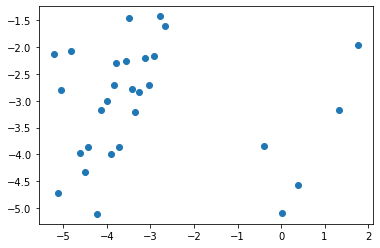

In [19]:
plt.scatter(est,real)

### task 1

In [16]:
stats.spearmanr(est_sub1,real_sub1)

SpearmanrResult(correlation=0.29550221259138043, pvalue=0.11963238125508804)

In [19]:
1 - spatial.distance.cosine(est_sub1,real_sub1)

0.0403516482952857

In [20]:
np.corrcoef(est_sub1,real_sub1)

array([[1.        , 0.02294597],
       [0.02294597, 1.        ]])

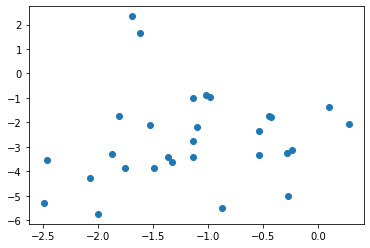

In [22]:
plt.scatter(est_sub1,real_sub1)

### task 2

In [17]:
stats.spearmanr(est_sub2,real_sub2)

SpearmanrResult(correlation=0.3269996501550306, pvalue=0.08337137472702995)

In [24]:
1 - spatial.distance.cosine(est_sub2,real_sub2)

0.6905724290271665

In [25]:
np.corrcoef(est_sub2,real_sub2)

array([[1.        , 0.67145035],
       [0.67145035, 1.        ]])

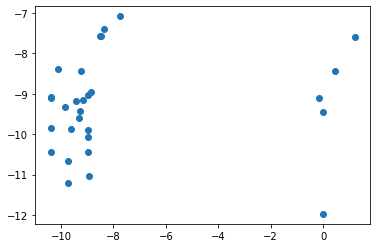

In [23]:
plt.scatter(est_sub2,real_sub2)

### task 3

In [18]:
stats.spearmanr(est_sub3,real_sub3)

SpearmanrResult(correlation=0.690259464316729, pvalue=3.41869410381304e-05)

In [28]:
1 - spatial.distance.cosine(est_sub3,real_sub3)

0.9582296238510127

In [29]:
np.corrcoef(est_sub3,real_sub3)

array([[1.        , 0.77240937],
       [0.77240937, 1.        ]])

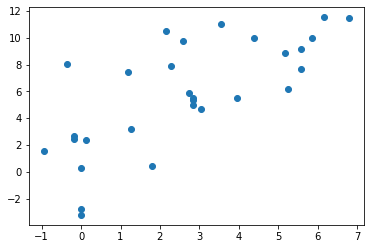

In [24]:
plt.scatter(est_sub3,real_sub3)